In [1]:
import numpy as np

import CDEF

import scipy.optimize
from scipy.optimize import root, Bounds

import time

#Plotting
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.ticker as ticker
from matplotlib.ticker import ScalarFormatter, NullFormatter

import os
from build123d import export_stl
from ocp_vscode import show


def bipyramid(R, h, base_corners=5, fillet_radius=0.0, center=(0,0,0), rotation=0.0):
    from build123d import Solid, Shell, Face, Wire, export_stl, fillet
    from scipy.spatial import ConvexHull
    import numpy as np

    def bipyramid_vertices(R, h, base_corners=5, center=(0,0,0), rotation=0.0):
        """Generate vertices of a bipyramid with a variable amount of base corners.

        Args:
            R (float): radius of the base.
            h (float): height of the apices above and below the base plane.
            center (tuple): (x, y, z) coordinates of the bipyramid center.
            rotation (float): rotation angle in radians applied to the base pentagon.

        Returns:
            List of 7 tuples [(x,y,z), ...] representing the bipyramid vertices.
        """
        cx, cy, cz = center
        vertices = []
        
        # 5 vertices of pentagonal base in XY plane with rotation
        for i in range(base_corners):
            angle = 2 * np.pi * i / base_corners + rotation
            x = cx + R * np.cos(angle)
            y = cy + R * np.sin(angle)
            z = cz
            vertices.append((x, y, z))
        
        # apex vertex at +h and -h
        vertices.append((cx, cy, cz + h))
        vertices.append((cx, cy, cz - h))
        
        return vertices

    vertices = bipyramid_vertices(R=R, h=h, base_corners=base_corners, center=center, rotation=rotation)

    # Create a convex hull from the vertices
    hull = ConvexHull(vertices).simplices.tolist()

    # Create faces from the vertex indices
    faces = []
    for face_vertex_indices in hull:
        corner_vertices = [vertices[i] for i in face_vertex_indices]
        faces.append(Face(Wire.make_polygon(corner_vertices)))

    # Create the solid from the Faces
    bipy = Solid(Shell(faces)).clean()
    if fillet_radius > 0:
        bipy = fillet(bipy.edges(), radius=fillet_radius)
    return bipy


# Function to make 3D axes equal
def set_axes_equal(ax):
    """Make axes of 3D plot have equal scale so that spheres appear as spheres."""
    limits = np.array([ax.get_xlim3d(), ax.get_ylim3d(), ax.get_zlim3d()])
    centers = np.mean(limits, axis=1)
    max_range = 0.5 * np.max(limits[:,1] - limits[:,0])
    for center, setter in zip(centers, [ax.set_xlim3d, ax.set_ylim3d, ax.set_zlim3d]):
        setter(center - max_range, center + max_range)

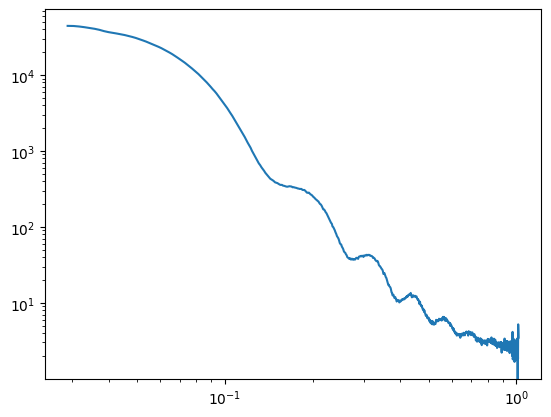

In [2]:
# Read measured data 

data = np.loadtxt("/messung/kmc/daten/2025/25_kw32/saxs_25_kw32/hdf_fcm_2025kw32_00097_Sample-Y_-8.0_Sample-X_44.7.dat")

fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1])

In [10]:
# create, show and export ideal pentagonal bipyramid

base_corners = 5
side_length = 1
height = side_length * 0.1 * np.sqrt(50-10*np.sqrt(5))
radius = side_length / (2*np.sin(np.pi/base_corners))
fillet_radius = radius * 0.0
port = 3939

bipy = bipyramid(R=radius, h=height, base_corners=base_corners, fillet_radius=fillet_radius)

show(bipy, port=port)

export_stl(bipy, "stl/bipy.stl")

RuntimeError: Cannot access viewer config. Is the viewer running?
("Cannot access viewer status. Is the viewer running?\n('none',)",)

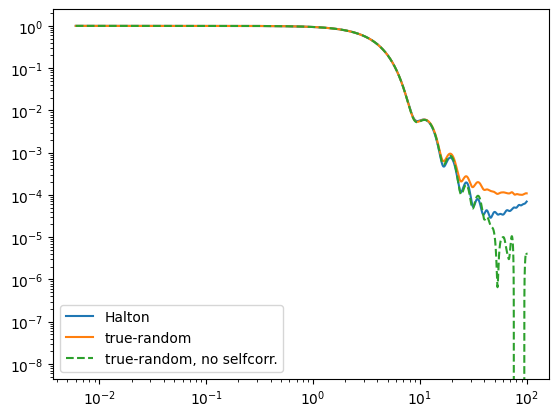

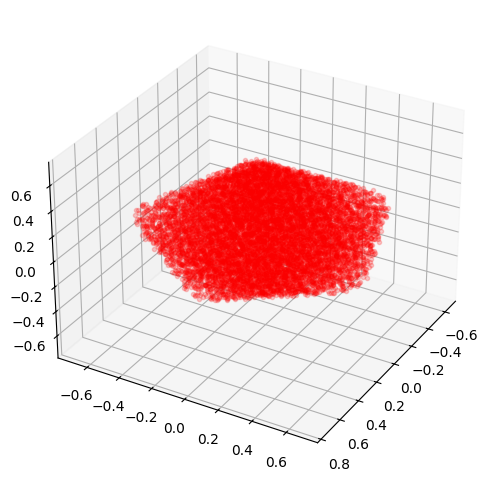

In [4]:
# Compute single-particle scattering curve
# number of scatterers
N = 30000

# generates 3D triangular mesh out of stl-files
# ideal bipyramid

test_mesh = CDEF.read_stl('stl/bipy.stl')

# cloud of punctiform scatterers based on mesh 
# from Halton series. Possible other values: sobol, random
#
test_cloud = CDEF.stl_cloud(test_mesh, N, sequence='halton')
test_cloud_random = CDEF.stl_cloud(test_mesh, N, sequence='random')

# single-particle scattering curve
# rbins - number of bins
# 
test_curve = CDEF.scattering_mono(test_cloud, selfcorrelation=True)
test_curve_random = CDEF.scattering_mono(test_cloud_random, selfcorrelation=True)
#
#no selfcorrelation
test_curve_random_no_selfcorr = CDEF.scattering_mono(test_cloud_random, selfcorrelation=False)


fig, ax = plt.subplots()
ax.loglog(test_curve[:,0], test_curve[:,1], label = "Halton")
ax.loglog(test_curve_random[:,0], test_curve_random[:,1], label = "true-random")
ax.loglog(test_curve_random_no_selfcorr[:,0], test_curve_random_no_selfcorr[:,1], '--', label = "true-random, no selfcorr.")
ax.legend()


#Visualization of point cloud
fig = plt.figure(figsize=(8,6)) 

ax = fig.add_subplot(111, projection='3d')

ax.plot(test_cloud.T[0], test_cloud.T[1], test_cloud.T[2], "r.", alpha=0.2) 

ax.view_init(30, 30)
set_axes_equal(ax)  # <-- apply equal aspect
plt.show()

Prior to fitting the experimental data $I_{\mathrm{EXP}}$, we want to plot the initial fit parameters $(q, \, N_{C}, \, \mathrm{mean}, \, \sigma, \, c_0)$ of our model/fit function $I_{\mathrm{MOD}}$ to check if our guess is close enought to a possible minimum of the parameter space of 

\begin{align}
\chi ^2 = \frac{1}{N_{q} - M} \sum_{i}^{N_{q}} \Big( \frac{I_{\mathrm{EXP}}(q_{i}) - I_{\mathrm{MOD}} (q_{i})}{\sigma (I_{\mathrm{EXP}} (q_{i}))} \Big)^2
\end{align}

with 


\begin{align}
I_{\mathrm{MOD}} (q, \, N_{C}, \, \mathrm{mean}, \, \sigma, \, c_0) =  N_{\mathrm{C}} \, \int_{0}^{\infty} d(R \mathrm{;} \, \mathrm{mean}, \, \sigma) \, \vert F(q,R) \vert^2 \, dR + c_0,
\end{align}

and $d(R \mathrm{;} \, \mathrm{mean}, \, \sigma)$ being the size distribution chosen.

Optimization terminated successfully.
         Current function value: 19.149878
         Iterations: 6
         Function evaluations: 431
Calculation time = 47.22231912612915 s


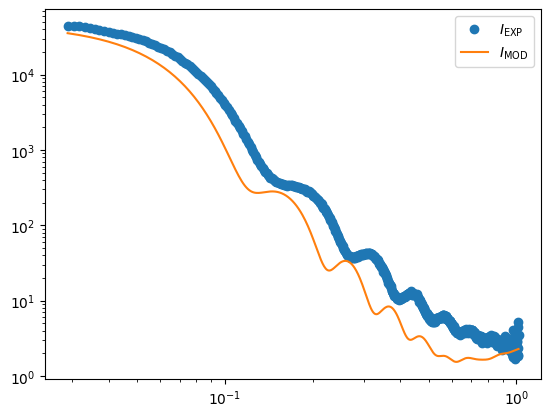

In [5]:
#Initial guess of fit parameters must be fit
N_C, mean, sigma, c0 =  1e-06, 50, 2, 0
inital_guess = N_C, mean, sigma, c0
########################################

initial_fit = CDEF.scattering_model(test_curve, data[:,0],*inital_guess)
fig, ax = plt.subplots()
ax.loglog(data[:,0], data[:,1], 'o', label = "$I_{\mathrm{EXP}}$")
ax.loglog(initial_fit[:,0], initial_fit[:,1],'-', label = "$I_{\mathrm{MOD}}$")
ax.legend()

#Lognormal distribution
distribution = 'lognormal'
tic = time.time()
fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, test_curve, distribution), 
                                     method = 'Powell', options={'disp' : True})
toc = time.time()
print('Calculation time = {} s'.format(toc-tic))

The fit results of the $\mathrm{mean}$ as well as $\sigma$ refer to half of the length of the largest bounding box edge which is normalized to unity, i.e. for a cube, the values of these fit variables must be multiplied by $2$ to get the face-to-face distance and the according standard deviation.

In [6]:
#Results of parameters
print(fit_result.x)

#q-range of fit
qvec = np.logspace(-3,0,1000)

fit = CDEF.scattering_model(test_curve, qvec, *fit_result.x, distribution)

[3.39854022e-06 4.14126037e+01 3.28507330e+00 1.42152567e+00]


In [7]:
# R1: [3.57040599e-06, 4.77441195e+01, 1.76462874e+00, 8.27736992e-01]

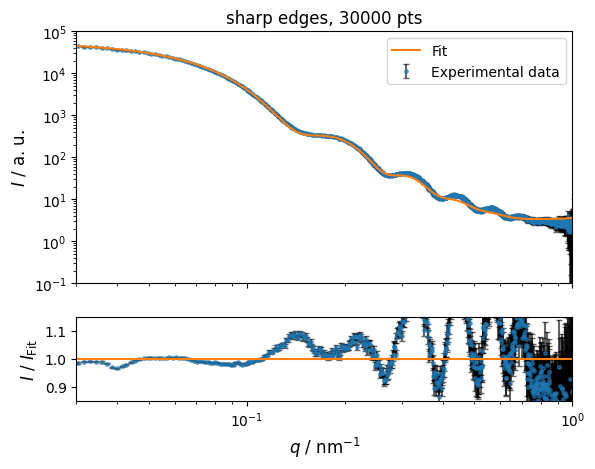

In [8]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

ax[0].set_title('sharp edges, {} pts'.format(N))
ax[0].set_xscale('log')
ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
ax[0].set_yscale('log')

#Frame limits
ax[0].set_ylim([1e-1, 1e5])
ax[0].set_xlim([3e-2, 1e0])

ax[0].errorbar(data[:,0], data[:,1], 
               yerr = data[:,2], fmt='.', ecolor='k', 
               capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

ax[0].legend()

#########################################
ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

#Frame limits
ax[1].set_ylim([0.85, 1.15])

ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
              yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
               fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
               label = 'Experimental data', zorder=1)

ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

plt.show()

fig.savefig(os.path.join("plots", f"pentagonal_bipyramid.png"))

# Try different edge roundings

In [17]:

import os
import re

def next_folder(prefix, base_dir="."):
    """
    Find the next folder with prefix_xxxx in base_dir.
    If none exists, create prefix_0000.
    Otherwise, create prefix_<max+1> with leading zeros.
    """
    # Regex to match prefix_XXXX where XXXX are digits
    pattern = re.compile(rf"^{prefix}_(\d{{4}})$")
    
    max_num = -1
    for name in os.listdir(base_dir):
        match = pattern.match(name)
        if match:
            num = int(match.group(1))
            max_num = max(max_num, num)
    
    # Determine next number
    next_num = max_num + 1 if max_num >= 0 else 0
    folder_name = f"{prefix}_{next_num:04d}"
    folder_path = os.path.join(base_dir, folder_name)
    
    os.makedirs(folder_path, exist_ok=False)  # fail if it already exists
    return folder_path


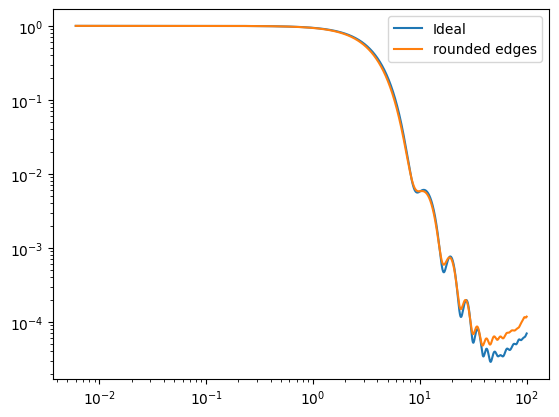

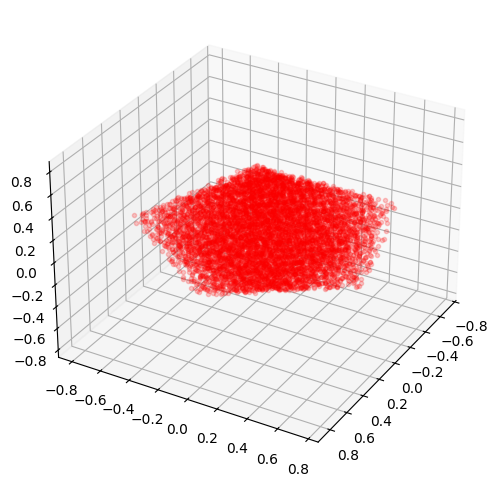

Optimization terminated successfully.
         Current function value: 20.620047
         Iterations: 7
         Function evaluations: 395
Calculation time = 43.06579279899597 s
[4.23459547e-06 4.66980329e+01 1.46682097e+00 1.26150059e-01]


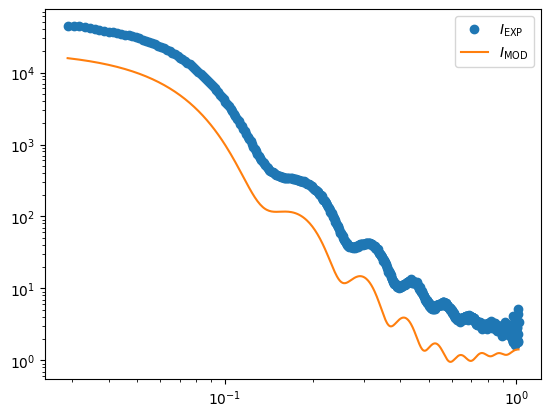

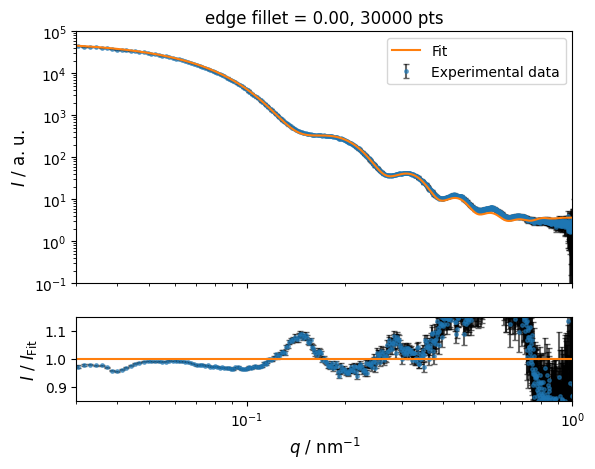

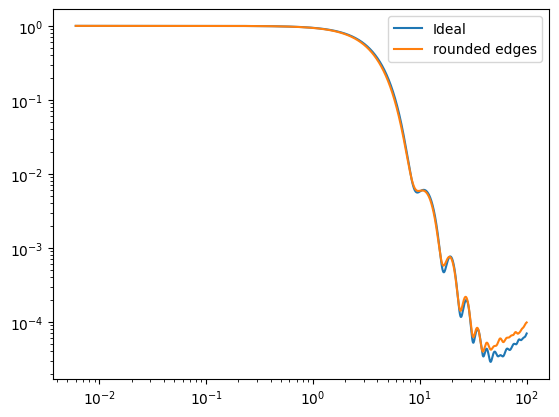

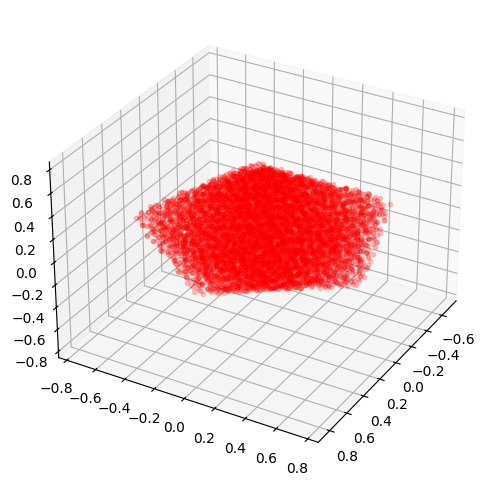

Optimization terminated successfully.
         Current function value: 8.194254
         Iterations: 8
         Function evaluations: 449
Calculation time = 48.63770914077759 s
[ 3.41054412e-06  4.56777448e+01 -2.25427194e+00  1.05411460e+00]


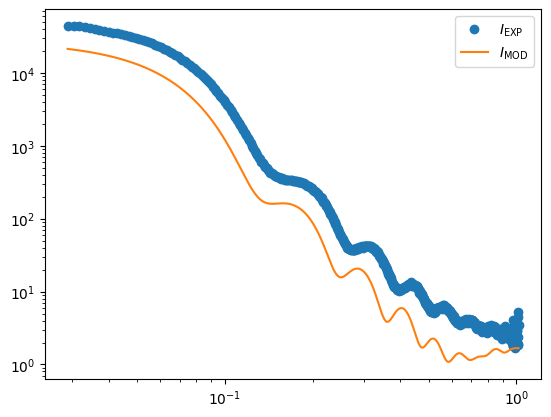

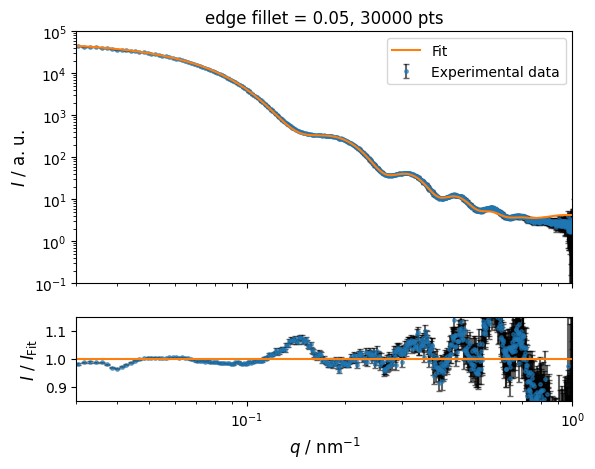

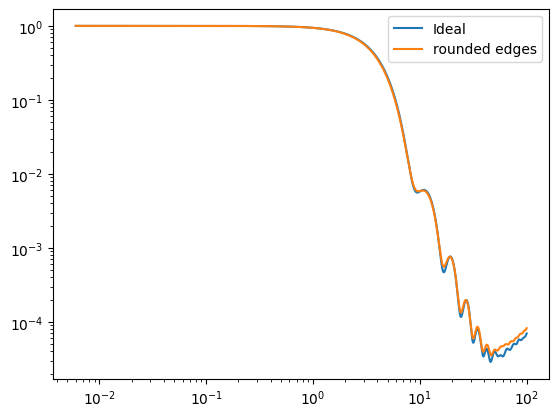

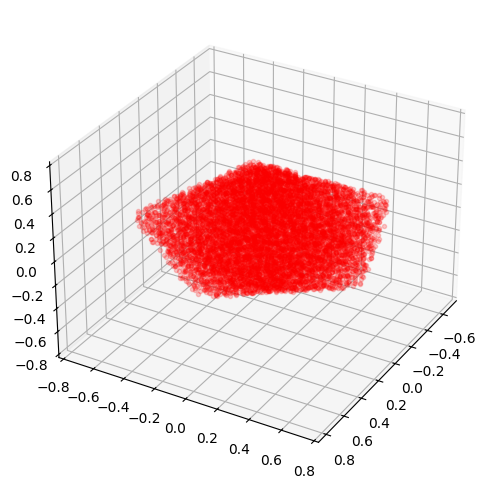

Optimization terminated successfully.
         Current function value: 10.544395
         Iterations: 12
         Function evaluations: 831
Calculation time = 89.75195026397705 s
[ 3.37826128e-06  4.42303253e+01 -2.66820301e+00  1.61909663e+00]


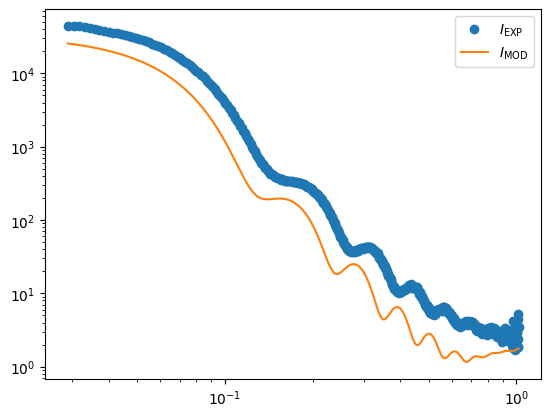

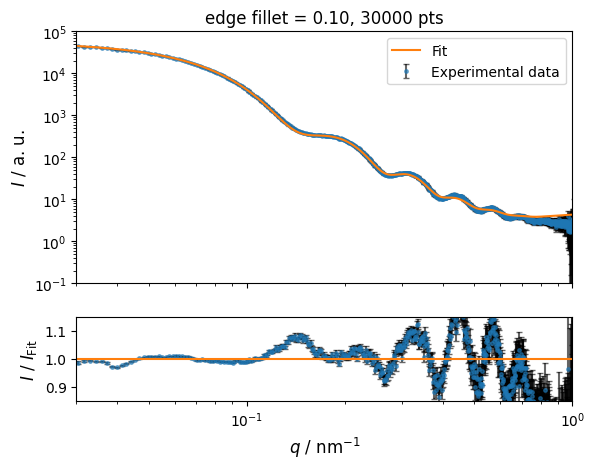

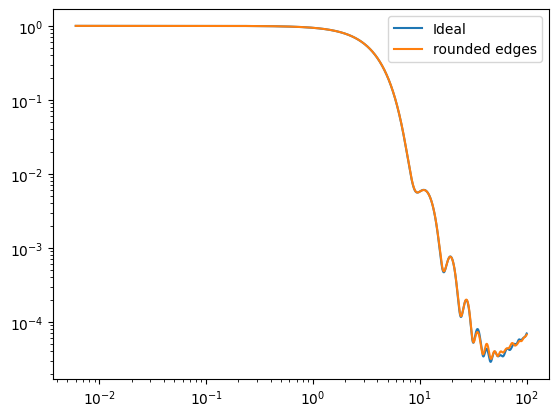

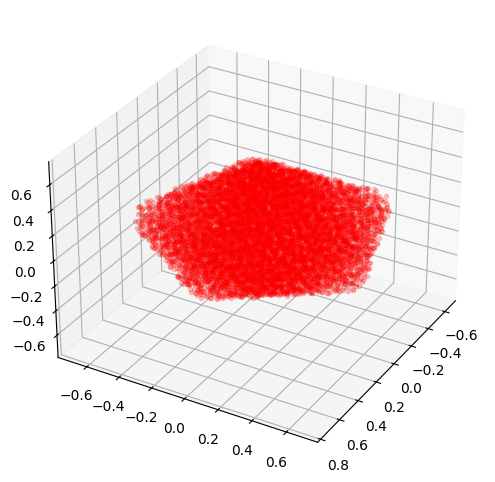

In [ ]:
import os

for rounding in [0.0, 0.05, 0.10, 0.15]:

    filename = 'stl/bipy.stl'

    fillet_radius = radius * rounding

    bipy = bipyramid(R=radius, h=height, base_corners=base_corners, fillet_radius=fillet_radius)

    export_stl(bipy, filename)

    # generates 3D triangular mesh out of stl-files
    test_mesh_round = CDEF.read_stl(filename)

    # cloud of punctiform scatterers based on mesh 
    test_cloud_round = CDEF.stl_cloud(test_mesh_round, N, sequence='halton')

    # single-particle scattering curve
    test_curve_round = CDEF.scattering_mono(test_cloud_round, selfcorrelation=True)

    fig, ax = plt.subplots()
    ax.loglog(test_curve[:,0], test_curve[:,1], label = "Ideal")
    ax.loglog(test_curve_round[:,0], test_curve_round[:,1], label = "rounded edges")
    ax.legend()


    #Visualization of point cloud with rounded edges
    fig = plt.figure(figsize=(8,6)) 
    ax = fig.add_subplot(111, projection='3d')
    ax.plot(test_cloud_round.T[0], test_cloud_round.T[1], test_cloud_round.T[2], "r.", alpha=0.2) 
    ax.view_init(30, 30)
    set_axes_equal(ax)  # <-- apply equal aspect
    plt.show()

    #Initial guess of fit parameters
    N_C, mean, sigma, c0 =  1e-06, 50, 0.2, 0
    inital_guess = N_C, mean, sigma, c0

    distribution = 'lognormal'

    initial_fit = CDEF.scattering_model(test_curve_round, data[:,0],*inital_guess, distribution)
    fig, ax = plt.subplots()
    ax.loglog(data[:,0], data[:,1], 'o', label = "$I_{\mathrm{EXP}}$")
    ax.loglog(initial_fit[:,0], initial_fit[:,1],'-', label = "$I_{\mathrm{MOD}}$")
    ax.legend()

    #Fit
    tic = time.time()
    fit_result = scipy.optimize.minimize(CDEF.chi_squared, (inital_guess), args=(data, test_curve_round, distribution), 
                                        method = 'Powell', options={'disp' : True})
    toc = time.time()
    print('Calculation time = {} s'.format(toc-tic))

    #Results of parameters
    print(fit_result.x)

    #q-range of fit
    qvec = np.logspace(-3,0,1000)

    fit = CDEF.scattering_model(test_curve_round, qvec, *fit_result.x, distribution)

    # show results
    fig, ax = plt.subplots(nrows=2, ncols=1, sharex='col', sharey='row', gridspec_kw={'height_ratios':[3,1]})

    ax[0].set_title(f'edge fillet = {rounding:.2f}, {N} pts')
    ax[0].set_xscale('log')
    ax[0].set_ylabel(r'$I$ / a. u.', fontsize=12)
    ax[0].set_yscale('log')

    #Frame limits
    ax[0].set_ylim([1e-1, 1e5])
    ax[0].set_xlim([3e-2, 1e0])

    ax[0].errorbar(data[:,0], data[:,1], 
                yerr = data[:,2], fmt='.', ecolor='k', 
                capsize= 2, capthick=1, alpha=0.6, markersize = 5, label = 'Experimental data', zorder=1)
    ax[0].loglog(fit[:,0], fit[:,1], label='Fit')

    ax[0].legend()

    #########################################
    ax[1].set_xlabel(r'$q$ / nm$^{-1}$', fontsize=12)
    ax[1].set_ylabel(r'$I$ / $I_{\mathrm{Fit}}$', fontsize=12)

    #Frame limits
    ax[1].set_ylim([0.85, 1.15])

    ax[1].errorbar(data[:, 0], data[:, 1]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                yerr = data[:, 2]/np.interp(data[:, 0], fit[:,0], fit[:,1]), 
                fmt='.', ecolor='k', capsize= 2, capthick=1, alpha=0.6, markersize = 5, 
                label = 'Experimental data', zorder=1)

    ax[1].plot(fit[:,0], fit[:,1]/fit[:,1], label='Fit')

    plt.show()

    prefix = f"start_{inital_guess[0]:.1g}_{inital_guess[1]:.0f}_{inital_guess[2]:.1f}_{inital_guess[3]:.1f}"
    parent_path = "/home/ulmer01/saxs/CDEF/plots"
    new_folder = next_folder(prefix, parent_path)
    fig.savefig(os.path.join("plots", f"pentabipy_{rounding:.2f}.png"))

Created: /home/ulmer01/saxs/CDEF/plots/start_1e-06_50_0.2_0.0_0001
